# Kvalitetskontroll av budgetdata 2022

In [280]:
import pandas as pd
%config InlineBackend.figure_format = 'retina'

## Detailed party budgets

In [281]:
opposition_parties = ['c', 'kd', 'l', 'm', 'sd', 'v']
data_path = '../data'
frames = []

for party in opposition_parties:
    frame = pd.read_csv(f'{data_path}/budgetmotion-2022-{party}.csv', dtype=str)
    frame['Parti'] = party.upper()
    frames.append(frame)

In [282]:
df = pd.concat(frames, sort=False)

In [283]:
df['Utgiftsområde'] = df['Utgiftsområde'].astype(int)
df['2022'] = df['2022'].astype(int)
df['2023'] = df['2023'].astype(float).astype('Int64')
df['2024'] = df['2024'].astype(float).astype('Int64')

## Summary party budgets

In [284]:
sums = pd.read_csv('../data/budgetmotion-2022-summor.csv')
sums = sums[sums['Utgiftsområde'] < 26]
sums = sums.set_index(['Parti', 'Utgiftsområde'])
sums = sums.drop('Namn', axis=1)

In [285]:
# Sums derived from detailed posts
calc_sums = df.groupby(['Parti', 'Utgiftsområde']).sum()

## Sanity check

In [286]:
# Convert to MSEK for better overview
sums = sums / 1_000_000
calc_sums = calc_sums / 1_000_000

In [287]:
calc_sums.head()

2022   2023   2024
Parti Utgiftsområde                     
C     1               25.0  -19.0  -15.0
      2              252.0  -39.0  -39.0
      3               27.0    0.0    0.0
      4              361.0  446.0  491.0
      5                4.0    2.0    2.0

In [288]:
sums.head()

2022    2023    2024
Parti Utgiftsområde                        
KD    1              -148.5  -192.0  -192.0
      2               137.0   152.0   202.0
      3               130.0   140.0   140.0
      4              1593.0  1920.0  3575.0
      5               -14.0   -16.0   -18.0

In [289]:
sums.shape

(150, 3)

In [290]:
sums.index.difference(calc_sums.index)

MultiIndex([( 'C',  7),
            ( 'M',  5),
            ('SD', 19)],
           names=['Parti', 'Utgiftsområde'])

In [291]:
# Drop the diffing rows
sums = sums.drop(sums.index.difference(calc_sums.index))

In [292]:
# Rows that differ for 2022
_ = '2022'
calc_sums[(calc_sums[_].abs() - sums[_].abs() > 2)].merge(sums, left_index=True, right_index=True)[[f'{_}_x', f'{_}_y']]

2022_x  2022_y
Parti Utgiftsområde                
SD    12               51.0    31.0
      14            -5320.0 -5060.0

In [293]:
# Rows that differ for 2023
_ = '2023'
calc_sums[(calc_sums[_].abs() - sums[_].abs() > 2)].merge(sums, left_index=True, right_index=True)[[f'{_}_x', f'{_}_y']]

2023_x  2023_y
Parti Utgiftsområde                 
L     16              4422.0  4414.0
SD    8              -3101.0 -2784.0
      14            -6860.34 -6600.0

In [296]:
# Rows that differ for 2024
_ = '2024'
calc_sums[(calc_sums[_].abs() - sums[_].abs() > 2)].merge(sums, left_index=True, right_index=True)[[f'{_}_x', f'{_}_y']]

2024_x  2024_y
Parti Utgiftsområde                 
L     9               3453.0  3450.0
      16              1759.0  1754.0
SD    8              -4327.0 -3724.0
      12              -147.0   -57.0
      14            -6434.31 -6174.0

In [297]:
piv = df.drop(['2023', '2024', 'Namn'], axis=1)

In [298]:
piv = piv[~piv.Anslag.str.startswith('99', na=False)]

In [299]:
piv['2022'] = piv['2022'].astype(float) / 1_000_000

In [300]:
piv = piv.pivot_table(index=['Utgiftsområde', 'Anslag'], columns='Parti', values='2022')

In [301]:
piv = piv.fillna(0)

In [302]:
piv

Parti                     C      KD       L       M      SD        V
Utgiftsområde Anslag                                                
1             1:1       0.0     0.0     0.0     0.0     3.0    -15.0
              2:1       0.0     0.0    -1.0     0.0     0.0   -131.0
              2:2       0.0     0.0    -2.0    10.0    10.0      0.0
              2:3       0.0     0.0     0.0     0.0     0.0      0.0
              2:4       0.0     0.0     5.0     0.0     0.0      0.0
...                     ...     ...     ...     ...     ...      ...
25            1:1     379.0  4824.0  1166.0  5649.0  3000.0  21771.0
              1:2       0.0     0.0     0.0     0.0     0.0      0.0
              1:3       0.0     0.0     0.0     0.0     0.0      0.0
              1:4       0.0     0.0     0.0     0.0     0.0      0.0
              1:5       0.0     0.0     0.0     0.0     0.0      0.0

[492 rows x 6 columns]

<AxesSubplot:ylabel='Parti'>

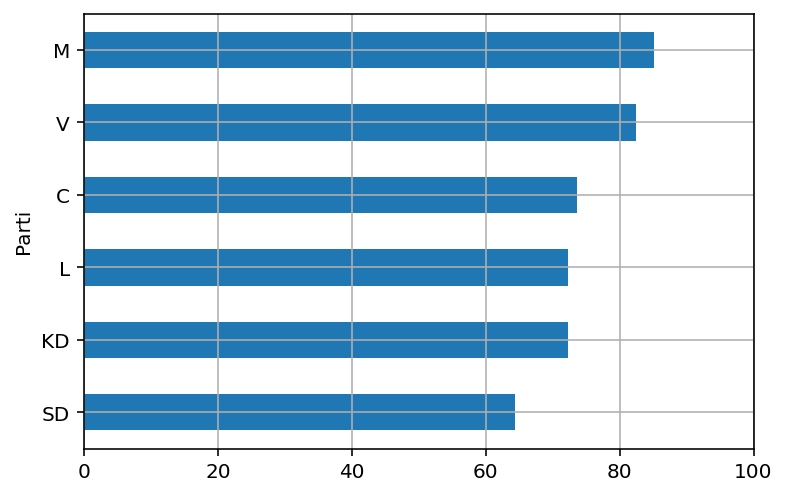

In [303]:
((piv.apply(lambda x: x == 0, axis=1).sum().sort_values() + 2) / 492 * 100).plot.barh(xlim=(0, 100), grid=True)

In [304]:
df[df.Anslag.str.startswith('99', na=False)].Parti.value_counts()

SD    52
KD    30
V     23
C      5
L      5
M      4
Name: Parti, dtype: int64

In [252]:
name_map = df[['Utgiftsområde', 'Anslag', 'Namn']].drop_duplicates(subset=['Utgiftsområde', 'Anslag'])

In [254]:
df = (df
    .pivot_table(index=['Anslag', 'Utgiftsområde'],
                 columns=['Parti'],
                 values='2022')
    .reset_index())

In [256]:
df = df.fillna(0)

In [209]:
gov = pd.read_csv('../data/budgetproposition-2022-regering.csv', dtype=str)

In [226]:
gov[gov.Utgiftsområde.astype(int) < 26].dropna(subset=['Anslag', 'Underområde'], how='any')

,Utgiftsområde,Underområde,Anslag,Namn,2022
2,1,1,1,Kungliga hov- och slottsstaten,149157000
4,1,2,1,Riksdagens ledamöter och partier m.m.,981205000
5,1,2,2,Riksdagens förvaltningsanslag,984675000
6,1,2,3,Riksdagens fastighetsanslag,120000000
7,1,2,4,Riksdagens ombudsmän (JO),123577000
...,...,...,...,...,...
570,25,1,1,Kommunalekonomisk utjämning,147046689000
571,25,1,2,Utjämningsbidrag för LSS-kostnader,4718355000
572,25,1,3,Bidrag till kommunalekonomiska organisationer,7150000
573,25,1,4,Tillfälligt stöd till enskilda kommuner och re...,250000000


In [227]:
gov['Anslag'] = gov['Underområde'] + ':' + gov['Anslag']

In [230]:
gov[~gov.Anslag.isin(df.Anslag)]

,Utgiftsområde,Underområde,Anslag,Namn,2022


In [231]:
gov.Anslag.unique().shape

(157,)

In [233]:
gov['Kod'] = gov['Utgiftsområde'] + ':' + gov.Anslag

In [237]:
df['Kod'] = df['Utgiftsområde'].astype(str) + ':' + df.Anslag

In [239]:
gov[~gov.Kod.isin(df.Kod)]

,Utgiftsområde,Underområde,Anslag,Namn,2022,Kod
200,13,2,2:2,Åtgärder mot diskriminering och rasism m.m.,100919000,13:2:2
204,13,3,3:3,Bidrag för kvinnors organisering,28163000,13:3:3
576,26,1,1:1,Räntor på statsskulden,12000000000,26:1:1
577,26,1,1:2,Oförutsedda utgifter,10000000,26:1:2
578,26,1,1:3,Riksgäldskontorets provisionsutgifter,145200000,26:1:3
580,27,1,1:1,Avgiften till Europeiska unionen,47836848000,27:1:1


In [259]:
gov = gov.rename(columns={'2022': 'Regeringen'})

In [260]:
gov = gov.dropna(subset=['Anslag'])

In [262]:
df = df.merge(gov[['Anslag', 'Utgiftsområde', 'Regeringen', 'Namn']], on=['Utgiftsområde', 'Anslag'], how='left')

In [263]:
df = df[['Utgiftsområde', 'Anslag', 'Namn', 'Regeringen', 'C', 'KD', 'L', 'M', 'SD', 'V']]

In [264]:
df = df.fillna(0)

In [265]:
df.Regeringen = df.Regeringen.astype(float)

In [266]:
df.shape

(563, 10)

In [267]:
for col in ['C', 'KD', 'L', 'M', 'SD', 'V']:
    if not df[(df[col].abs() > df.Regeringen) & (df[col] < 0)].empty:
        print(col)

V


In [268]:
df[(df['V'].abs() > df.Regeringen) & (df['V'] < 0)]

,Utgiftsområde,Anslag,Namn,Regeringen,C,KD,L,M,SD,V
253,10,1:7,Ersättning för höga sjuklönekostnader,282000000.0,0.0,0.0,0.0,0.0,0.0,-400000000.0


In [269]:
df.to_csv('../data/budgetmotion-2022-main.csv', index=False)

In [270]:
for col in ['C', 'KD', 'L', 'M', 'SD', 'V']:
    df[col] = df[col].astype(int) / 1_000_000

In [271]:
for col in ['Regeringen']:
    df[col] = df[col].astype(float) / 1_000_000

In [272]:
for col in ['C', 'KD', 'L', 'M', 'SD', 'V']:
    df[f'{col}_prc'] = df[col] / df['Regeringen']

In [278]:
df

,Utgiftsområde,Anslag,Namn,Regeringen,C,KD,L,M,SD,V,C_prc,KD_prc,L_prc,M_prc,SD_prc,V_prc
0,17,10:1,Filmstöd,608.444,0.0,-155.0,0.0,0.0,-155.0,10.0,0.0,-0.254748,0.0,0.0,-0.254748,0.016435
1,17,11:1,Sändningar av TV Finland,9.721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,17,11:2,Forskning och dokumentation om medieutvecklingen,3.471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,17,11:3,Avgift till europeiska audiovisuella observato...,0.483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,17,11:4,Statens medieråd,24.144,0.0,0.0,0.0,0.0,-15.0,0.0,0.0,0.000000,0.0,0.0,-0.621272,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,17,99:9,0,0.000,0.0,0.0,0.0,0.0,300.0,0.0,NaN,NaN,NaN,NaN,inf,NaN
559,23,99:9,0,0.000,0.0,0.0,0.0,0.0,900.0,0.0,NaN,NaN,NaN,NaN,inf,NaN
560,1,9:1,Svenska institutet för europapolitiska studier...,31.550,0.0,0.0,0.0,0.0,-19.0,0.0,0.0,0.000000,0.0,0.0,-0.602219,0.000000
561,17,9:1,Myndigheten för stöd till trossamfund,16.327,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,0.0,0.183745,0.000000


In [276]:
p = df[df.Namn == 'Polismyndigheten']

In [277]:
p

,Utgiftsområde,Anslag,Namn,Regeringen,C,KD,L,M,SD,V,C_prc,KD_prc,L_prc,M_prc,SD_prc,V_prc
38,4,1:1,Polismyndigheten,32985.967,321.0,1315.0,400.0,863.0,3145.0,70.0,0.009731,0.039865,0.012126,0.026163,0.095344,0.002122


In [116]:
p

,Utgiftsområde,Anslag,Namn,Regeringen,C,KD,L,M,SD,V,C_prc,KD_prc,L_prc,M_prc,SD_prc,V_prc
29,4,1:1,Polismyndigheten,32985.967,321.0,1315.0,400.0,863.0,3145.0,70.0,0.009731,0.039865,0.012126,0.026163,0.095344,0.002122


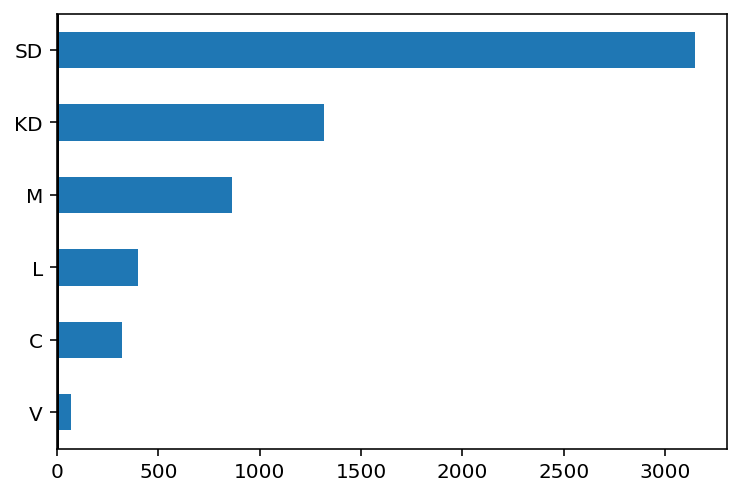

In [118]:
ax = p[['C', 'KD', 'L', 'M', 'SD', 'V']].T.sort_values(29).plot.barh(legend=False)
ax.axvline(1, c='#000000')